# Trajectory and Traffic Volume Visualization

This notebook visualizes flight trajectories and traffic volumes using Cartopy.
It shows:
1. Flight trajectories derived from impact vectors
2. Traffic volumes with their names and time windows
3. Interactive mapping using geographic projections

In [1]:
import json
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, LineString
import sys
import os

# Add the project source to path for imports
sys.path.append('../src')
from project_tailwind.impact_eval.tvtw_indexer import TVTWIndexer

plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

## Load Data

In [2]:
# Load impact vectors
with open('../output/impact_vectors.json', 'r') as f:
    impact_vectors = json.load(f)

print(f"Loaded {len(impact_vectors)} routes with impact vectors")
print("Sample routes:")
for i, (route, vectors) in enumerate(list(impact_vectors.items())[:3]):
    print(f"  {route}: {len(vectors)} impact indices")
    if i >= 2:
        break

Loaded 10 routes with impact vectors
Sample routes:
  BKPR AKIKA SOTOV EDMN EDJA: 5 impact indices
  BKPR ALELU GIMIX DETSA_10 KPT ALG_46 EDJA: 4 impact indices
  BKPR ERKIR EDNL EDJA: 4 impact indices


In [3]:
# Load traffic volumes
traffic_volumes = gpd.read_file('D:/project-cirrus/cases/traffic_volumes_simplified.geojson')
print(f"Loaded {len(traffic_volumes)} traffic volumes")
print("Traffic volume columns:", traffic_volumes.columns.tolist())
print("\nSample traffic volumes:")
print(traffic_volumes[['traffic_volume_id', 'min_fl', 'max_fl']].head())

Skipping field elementary_sectors: unsupported OGR type: 5


Loaded 622 traffic volumes
Traffic volume columns: ['traffic_volume_id', 'name', 'category', 'airspace_id', 'role', 'skip_in', 'skip_out', 'min_fl', 'max_fl', 'airblock_count', 'capacity', 'geometry']

Sample traffic volumes:
  traffic_volume_id  min_fl  max_fl
0          EBBUELS1      45     185
1          EBBUEHS4     185     245
2          EBBUHUS2      45     245
3          EBBULUS2      45     245
4          EBBUNLS1      45     255


In [5]:
# Load waypoint graph
waypoint_graph = nx.read_gml('D:/project-akrav/data/graphs/ats_fra_nodes_only.gml')
print(f"Loaded waypoint graph with {waypoint_graph.number_of_nodes()} nodes")

# Convert to DataFrame for easier handling
waypoint_data = []
for node_id, data in waypoint_graph.nodes(data=True):
    waypoint_data.append({
        'id': node_id,
        'label': node_id,
        'lat': float(data['lat']),
        'lon': float(data['lon'])
    })

waypoints_df = pd.DataFrame(waypoint_data)
print(f"\nSample waypoints:")
print(waypoints_df.head())

Loaded waypoint graph with 33763 nodes

Sample waypoints:
      id  label        lat        lon
0  RIDLA  RIDLA  45.749722  37.365000
1  UGZIR  UGZIR  45.890000  37.583333
2  ENILO  ENILO  46.174722  38.031667
3  SARZI  SARZI  46.596667  38.715833
4  AMEPU  AMEPU  47.197778  39.825000


In [6]:
# Load TVTW indexer
tvtw_indexer = TVTWIndexer.load('../output/tvtw_indexer.json')
print(f"TVTW indexer loaded with {len(tvtw_indexer._tv_id_to_idx)} traffic volumes")
print(f"Time bin size: {tvtw_indexer.time_bin_minutes} minutes")
print(f"Number of time bins per day: {tvtw_indexer.num_time_bins}")

TVTW indexer loaded with 622 traffic volumes
Time bin size: 30 minutes
Number of time bins per day: 48


## Process Route Trajectories

In [7]:
def parse_route_waypoints(route_string):
    """Parse route string to get waypoint names"""
    return route_string.split()

def get_route_coordinates(route_string, waypoints_df):
    """Get lat/lon coordinates for a route"""
    waypoint_names = parse_route_waypoints(route_string)
    coordinates = []
    
    for wp_name in waypoint_names:
        wp_data = waypoints_df[waypoints_df['label'] == wp_name]
        if not wp_data.empty:
            coordinates.append({
                'waypoint': wp_name,
                'lat': wp_data.iloc[0]['lat'],
                'lon': wp_data.iloc[0]['lon']
            })
        else:
            print(f"Warning: Waypoint {wp_name} not found in graph")
    
    return coordinates

# Process a subset of routes for visualization
sample_routes = list(impact_vectors.items())[:10]  # Take first 10 routes
route_geometries = []

for route_string, impact_vector in sample_routes:
    coords = get_route_coordinates(route_string, waypoints_df)
    if len(coords) >= 2:  # Need at least 2 points for a line
        lats = [c['lat'] for c in coords]
        lons = [c['lon'] for c in coords]
        route_geometries.append({
            'route': route_string,
            'geometry': LineString([(lon, lat) for lon, lat in zip(lons, lats)]),
            'impact_vector': impact_vector,
            'num_impacts': len(impact_vector)
        })

routes_gdf = gpd.GeoDataFrame(route_geometries, crs='EPSG:4326')
print(f"Created {len(routes_gdf)} route geometries for visualization")

Created 10 route geometries for visualization


## Analyze Traffic Volume Impacts

In [8]:
# Get impacted traffic volumes and their details
all_impact_indices = set()
for impact_vector in impact_vectors.values():
    all_impact_indices.update(impact_vector)

print(f"Total unique TVTW impact indices: {len(all_impact_indices)}")

# Convert impact indices to traffic volume information
impacted_tvs = []
for impact_idx in all_impact_indices:
    tvtw_info = tvtw_indexer.get_human_readable_tvtw(impact_idx)
    if tvtw_info:
        tv_id, time_window = tvtw_info
        impacted_tvs.append({
            'impact_index': impact_idx,
            'traffic_volume_id': tv_id,
            'time_window': time_window
        })

impacted_tvs_df = pd.DataFrame(impacted_tvs)
print(f"\nImpacted traffic volumes sample:")
print(impacted_tvs_df.head(10))

Total unique TVTW impact indices: 41

Impacted traffic volumes sample:
   impact_index traffic_volume_id  time_window
0           891           EDG3TAU  13:30-13:60
1          1802            EDMCA6  13:00-13:30
2          1419          EDG6PADL  13:30-13:60
3          2714            EDUD14  13:00-13:30
4          1946            EDMFUE  13:00-13:30
5           411           EDG1DUS  13:30-13:60
6           412           EDG1DUS  14:00-14:30
7          4778          EDUWU24X  13:00-13:30
8          2474            EDMTEG  13:00-13:30
9          3243          EDUFM24X  13:30-13:60


In [16]:
# Count impacts per traffic volume
tv_impact_counts = impacted_tvs_df['traffic_volume_id'].value_counts()
print(f"\nTop 10 most impacted traffic volumes:")
print(tv_impact_counts.head(10))

# Merge with traffic volume geometries
tv_with_impacts = traffic_volumes.merge(
    tv_impact_counts.reset_index().rename(columns={'count': 'impact_count'}),
    on='traffic_volume_id',
    how='left'
)
tv_with_impacts['impact_count'] = tv_with_impacts['impact_count'].fillna(0)

print(f"\nTraffic volumes with impact counts: {len(tv_with_impacts)}")
print(f"Traffic volumes with impacts > 0: {len(tv_with_impacts[tv_with_impacts['impact_count'] > 0])}")


Top 10 most impacted traffic volumes:
traffic_volume_id
EDUWU24X    2
EDG1DUS     2
EDUK14      2
EDG6PADH    2
EDUK1C      2
EDG3SIG     2
EDUI1C      2
EDG1BOT     2
EDUFM14X    2
EDUDI14     2
Name: count, dtype: int64

Traffic volumes with impact counts: 622
Traffic volumes with impacts > 0: 31


## Create Cartopy Visualization

In [17]:
# Calculate map bounds
all_bounds = []
if not routes_gdf.empty:
    all_bounds.extend(routes_gdf.total_bounds)
if not tv_with_impacts.empty:
    all_bounds.extend(tv_with_impacts.total_bounds)

if all_bounds:
    min_lon, min_lat = min(all_bounds[0::4]), min(all_bounds[1::4])
    max_lon, max_lat = max(all_bounds[2::4]), max(all_bounds[3::4])
    
    # Add some padding
    padding = 2  # degrees
    min_lon -= padding
    max_lon += padding
    min_lat -= padding
    max_lat += padding
else:
    # Default to Europe
    min_lon, max_lon = -10, 30
    min_lat, max_lat = 35, 65

print(f"Map bounds: lon({min_lon:.1f}, {max_lon:.1f}), lat({min_lat:.1f}, {max_lat:.1f})")

Map bounds: lon(-32.0, 33.7), lat(17.0, 73.3)


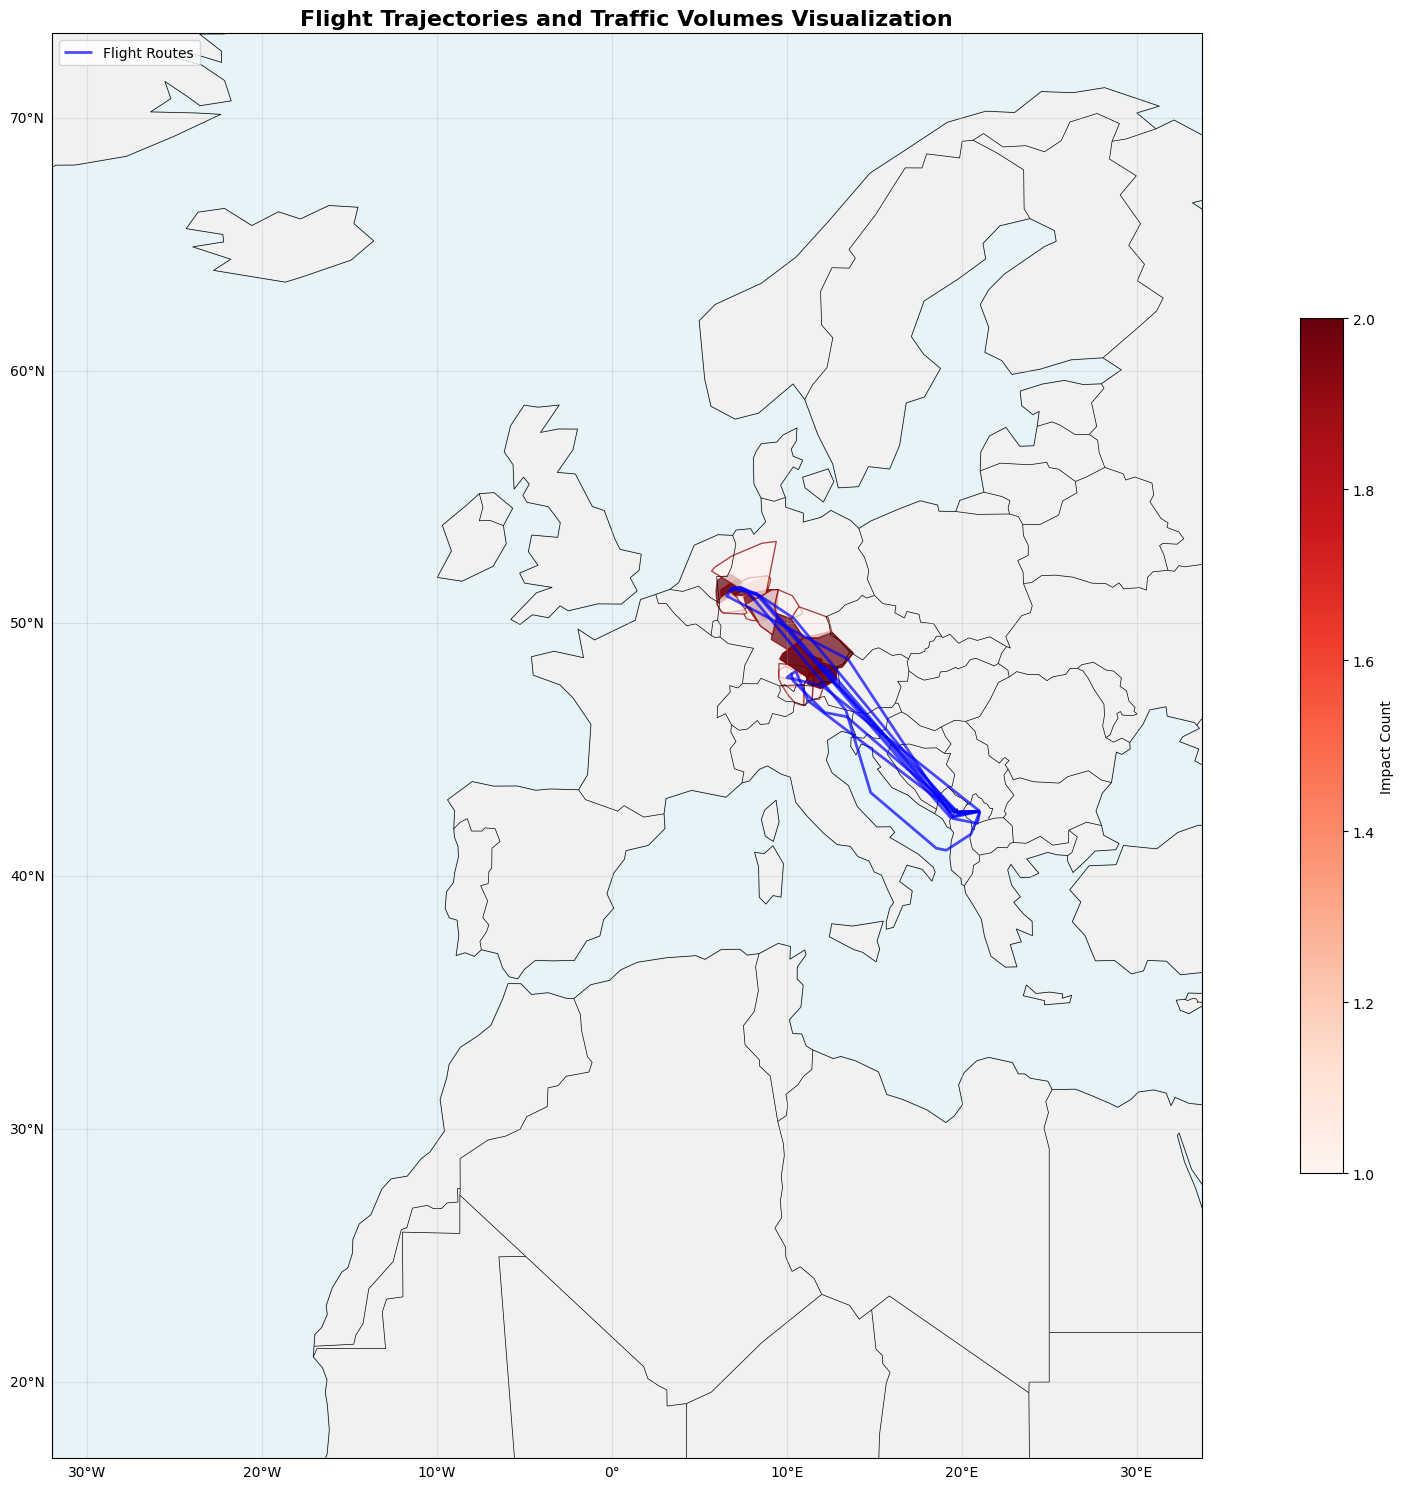

In [21]:
# Create the main visualization
fig = plt.figure(figsize=(20, 15))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
ax.add_feature(cfeature.OCEAN, alpha=0.3, color='lightblue')

# Add gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.3)
gl.top_labels = False
gl.right_labels = False

# Plot traffic volumes
if not tv_with_impacts.empty:
    # Plot all traffic volumes (lightly)
    # tv_with_impacts[tv_with_impacts['impact_count'] == 0].plot(
    #     ax=ax, 
    #     facecolor='lightcoral', 
    #     edgecolor='red', 
    #     alpha=0.2, 
    #     linewidth=0.5,
    #     label='Traffic Volumes (no impacts)'
    # )
    
    # Plot impacted traffic volumes (prominently)
    impacted_tvs_plot = tv_with_impacts[tv_with_impacts['impact_count'] > 0]
    if not impacted_tvs_plot.empty:
        impacted_tvs_plot.plot(
            ax=ax, 
            column='impact_count',
            cmap='Reds',
            alpha=0.7, 
            edgecolor='darkred',
            linewidth=1,
            legend=True,
            legend_kwds={'label': 'Impact Count', 'shrink': 0.6}
        )

# Plot routes
if not routes_gdf.empty:
    routes_gdf.plot(
        ax=ax, 
        color='blue', 
        alpha=0.7, 
        linewidth=2,
        label='Flight Routes'
    )

plt.title('Flight Trajectories and Traffic Volumes Visualization', fontsize=16, fontweight='bold')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Add Traffic Volume Labels

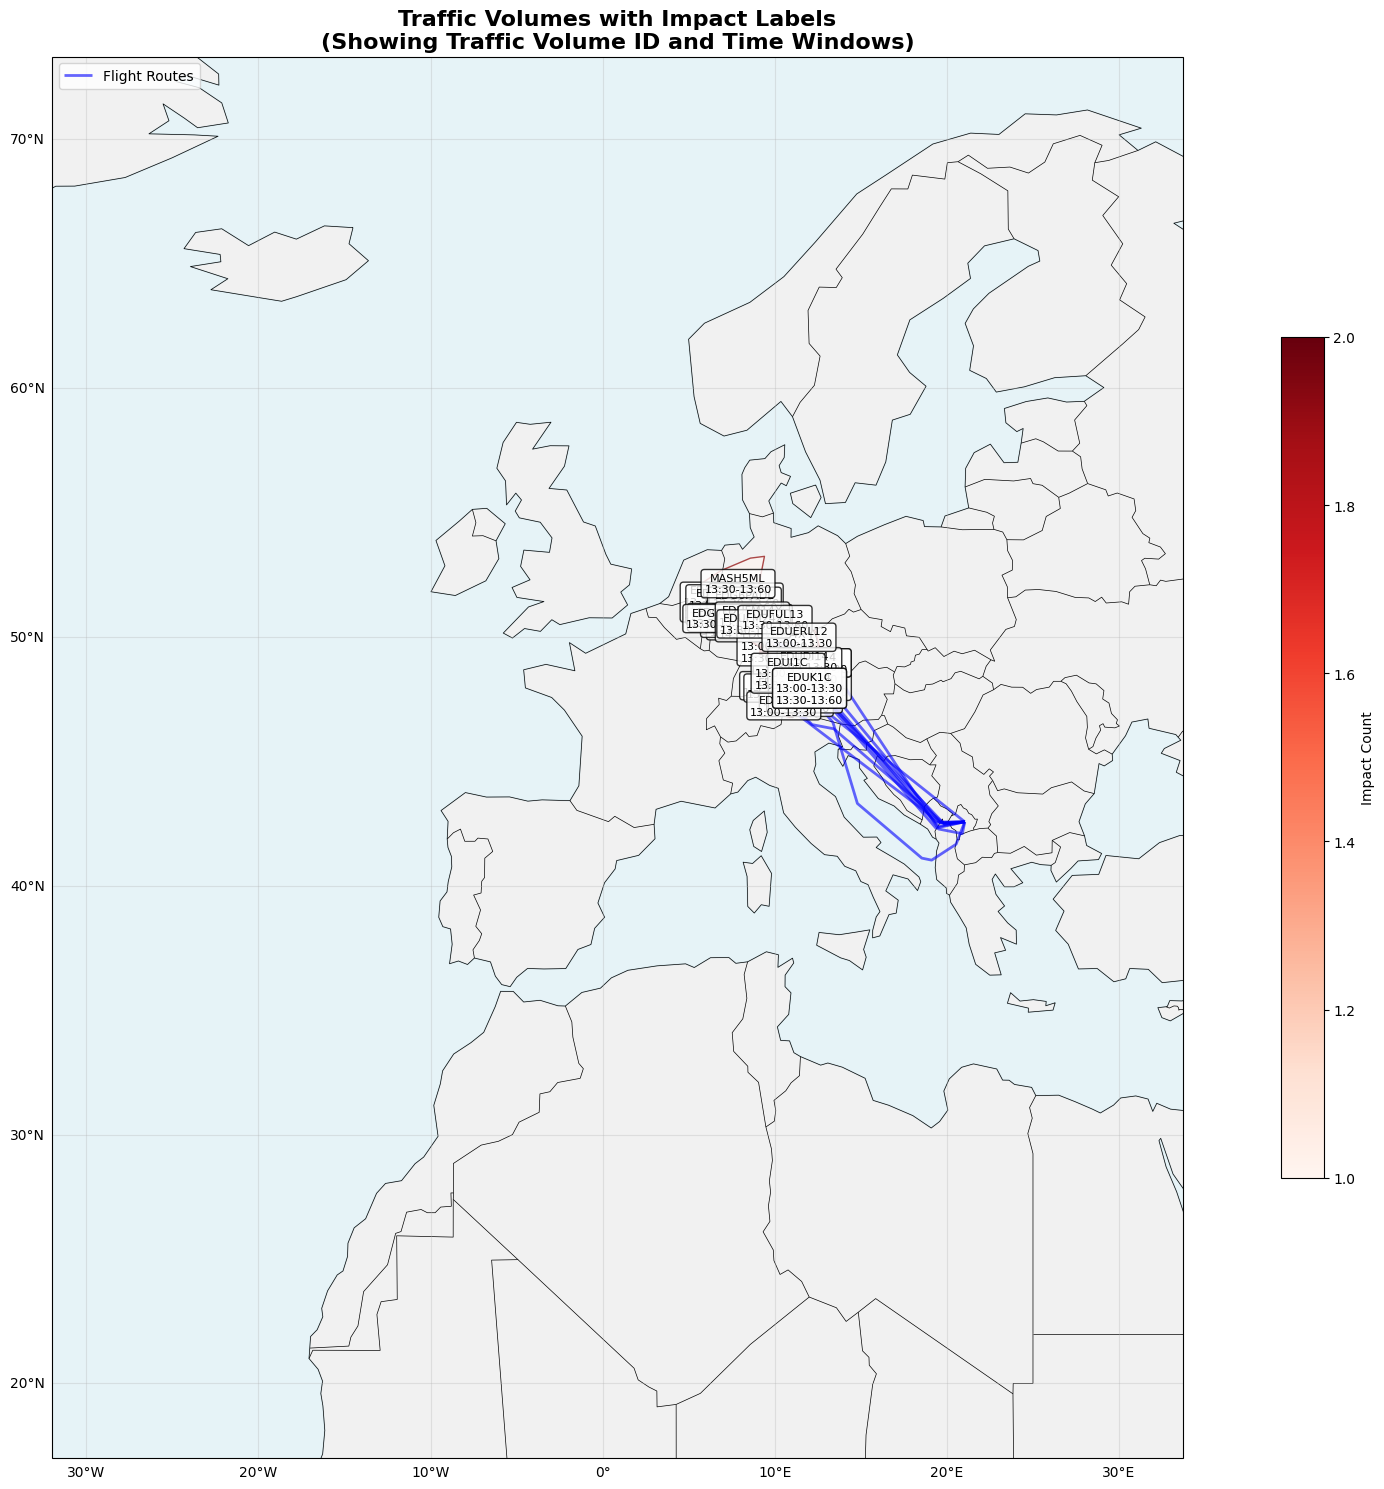

In [22]:
# Create a focused view with labels for impacted traffic volumes
fig = plt.figure(figsize=(20, 15))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
ax.add_feature(cfeature.OCEAN, alpha=0.3, color='lightblue')

# Add gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.3)
gl.top_labels = False
gl.right_labels = False

# Plot only impacted traffic volumes
if not tv_with_impacts.empty:
    impacted_tvs_plot = tv_with_impacts[tv_with_impacts['impact_count'] > 0]
    if not impacted_tvs_plot.empty:
        impacted_tvs_plot.plot(
            ax=ax, 
            column='impact_count',
            cmap='Reds',
            alpha=0.7, 
            edgecolor='darkred',
            linewidth=1,
            legend=True,
            legend_kwds={'label': 'Impact Count', 'shrink': 0.6}
        )
        
        # Add labels for traffic volumes
        for idx, tv in impacted_tvs_plot.iterrows():
            # Get centroid for label placement
            centroid = tv.geometry.centroid
            
            # Get time windows for this traffic volume
            tv_time_windows = impacted_tvs_df[
                impacted_tvs_df['traffic_volume_id'] == tv['traffic_volume_id']
            ]['time_window'].unique()
            
            # Create label text
            label_text = f"{tv['traffic_volume_id']}\n"
            if len(tv_time_windows) <= 3:
                label_text += "\n".join(tv_time_windows)
            else:
                label_text += f"{tv_time_windows[0]}\n...+{len(tv_time_windows)-1} more"
            
            # Add text annotation
            ax.text(
                centroid.x, centroid.y, 
                label_text,
                transform=ccrs.PlateCarree(),
                ha='center', va='center',
                fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
            )

# Plot routes
if not routes_gdf.empty:
    routes_gdf.plot(
        ax=ax, 
        color='blue', 
        alpha=0.6, 
        linewidth=2,
        label='Flight Routes'
    )

plt.title('Traffic Volumes with Impact Labels\n(Showing Traffic Volume ID and Time Windows)', 
          fontsize=16, fontweight='bold')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Summary Statistics

In [20]:
print("=== VISUALIZATION SUMMARY ===")
print(f"Total routes processed: {len(impact_vectors)}")
print(f"Routes visualized: {len(routes_gdf)}")
print(f"Total traffic volumes: {len(traffic_volumes)}")
print(f"Traffic volumes with impacts: {len(tv_with_impacts[tv_with_impacts['impact_count'] > 0])}")
print(f"Total unique TVTW impact indices: {len(all_impact_indices)}")
print(f"\nTime window configuration:")
print(f"  - Time bin size: {tvtw_indexer.time_bin_minutes} minutes")
print(f"  - Number of time bins per day: {tvtw_indexer.num_time_bins}")

if not impacted_tvs_df.empty:
    print(f"\nMost active time windows:")
    time_window_counts = impacted_tvs_df['time_window'].value_counts().head(10)
    for tw, count in time_window_counts.items():
        print(f"  {tw}: {count} impacts")

print("\n=== NOTES ===")
print("- Blue lines represent flight trajectories")
print("- Red polygons represent traffic volumes")
print("- Color intensity indicates impact frequency")
print("- Labels show traffic volume ID and active time windows")

=== VISUALIZATION SUMMARY ===
Total routes processed: 10
Routes visualized: 10
Total traffic volumes: 622
Traffic volumes with impacts: 31
Total unique TVTW impact indices: 41

Time window configuration:
  - Time bin size: 30 minutes
  - Number of time bins per day: 48

Most active time windows:
  13:30-13:60: 18 impacts
  13:00-13:30: 18 impacts
  14:00-14:30: 5 impacts

=== NOTES ===
- Blue lines represent flight trajectories
- Red polygons represent traffic volumes
- Color intensity indicates impact frequency
- Labels show traffic volume ID and active time windows
